In [77]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chi2_contingency, ttest_ind

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from pandas_profiling import ProfileReport

In [25]:
df = pd.read_csv(os.getcwd() + "/../data/data_test_technique.csv", sep=";")

# Question 0 : Analyse du DataSet

Nous allons créer un rapport Pandas Profiling afin de simplifier notre tache d'analyse

In [80]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [81]:
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Le rapport nous enseigne que: 
- Les colonnes "Unnamed: 0" et "id_individu" sont les mêmes et semblables à l'index
- Les variables "mortalite_intra_hosp" et "complication_intra_hosp" sont des binaires 0 ou 1. Elles ne sont pas uniformément distribuées dans le sens où le dataset comporte plus d'individus en vie et qui n'ont pas eu de complication au cours de leur hospitalisation
- Toutes les autres variables sont binaires sauf l'âge qui est continue
- Il n'y a pas de valeurs manquantes et de valeurs extrêmes

## Question 1 

In [28]:
len(list(df[(df["age"]>60) & (df["ic_atcd"]==1) & (df["hypertension_atcd"]==1)]["id_individu"]))

251

Il y a 251 individus de plus de 60 ans et présentant un antécédent d’insuffisance cardiaque ou d’hypertension

## Question 2

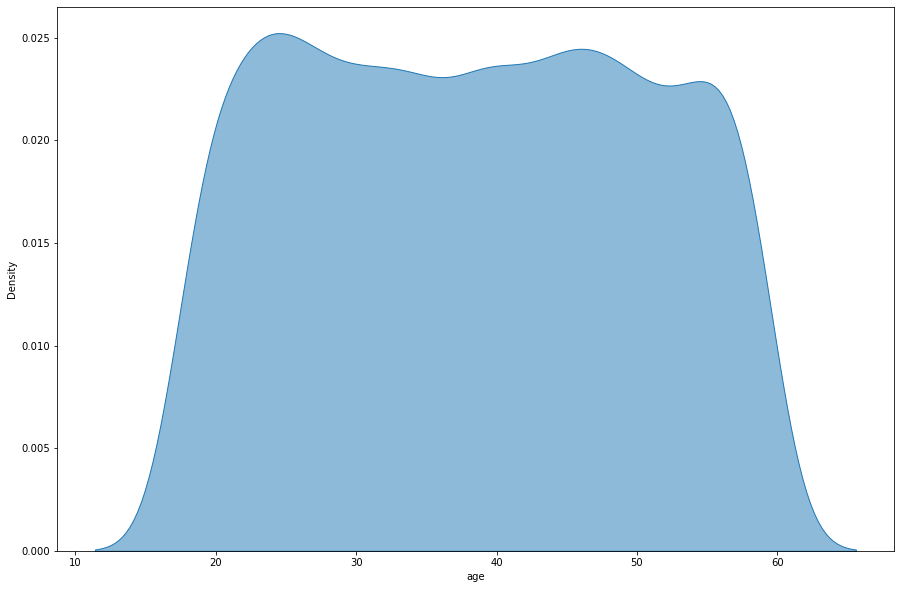

In [39]:
plt.figure(figsize=(15,10))
sns.kdeplot(data=df[df["age"]<60], x="age", fill=True, alpha=0.5)
plt.show()

/Users/karimderouiche/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


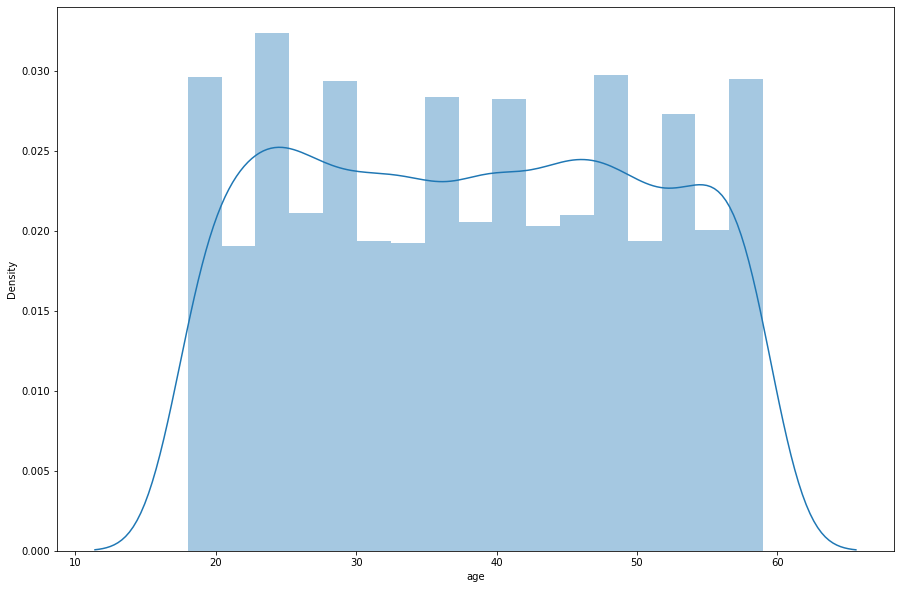

In [36]:
plt.figure(figsize=(15,10))
sns.distplot(df[df["age"]<60]["age"], kde=True, hist=True)
plt.show()

## Question 3

Nous allons effectuer un test du Chi 2 pour tester l'indépendance entre deux variables catégorielles.
Les hypothèses sont les suivantes:
- Ho: Les variables "age moins de 60 ans" et "avoir un antécédant d'insuffisance cardiaques" sont indépendantes 
- H1: Elles ne le sont pas

In [45]:
df["moins60"] = df["age"]<60

In [47]:
df_chi2 = pd.crosstab(df["moins60"], df["ic_atcd"])

In [48]:
df_chi2

ic_atcd,0,1
moins60,,
False,3456,1445
True,3538,1561


In [50]:
pval = chi2_contingency(df_chi2)[1]

In [51]:
pval

0.2261844744358967

La p-value n'est pas inférieur à 0,05, nous n'avons donc pas rejeté l'hypothèse nulle à un niveau de confiance de 95 %. Les variables semblent être indépendantes.

## Question 4

Nous allons effectuer un test de student.
Les hypothèses sont les suivantes:
- Ho: Il y a une différence 
- H1: Il n'y a pas de différence

In [55]:
t_stat, pval = ttest_ind(df.query("ic_atcd==1")["age"], df.query("ic_atcd==0")["age"])

In [58]:
pval

0.3130688211280792

La p-value n'est pas inférieur à 0,05, nous n'avons donc pas rejeté l'hypothèse nulle à un niveau de confiance de 95 %. Il ne semble pas y avoir de différence statistiquement significative

## Question 5

### Modèles univariés

In [71]:
var_for_multivar = []
for var in ['mortalite_intra_hosp', 'age', 'ic_atcd', 'hypertension_atcd', 
            'aoc_atcd', 'aoc_post_hosp', 'pacemaker_hist', 'cardio_consultation_hist']:
    Xtrain = df[var]
    ytrain = df["complication_intra_hosp"]
    Xtrain = sm.add_constant(Xtrain)

    log_reg = sm.Logit(ytrain, Xtrain).fit()
    print(log_reg.summary())
    
    if log_reg.pvalues[1] < 0.2:
        var_for_multivar.append(var)

Optimization terminated successfully.
         Current function value: 0.347284
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     complication_intra_hosp   No. Observations:                10000
Model:                               Logit   Df Residuals:                     9998
Method:                                MLE   Df Model:                            1
Date:                     Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2872
Time:                             20:35:34   Log-Likelihood:                -3472.8
converged:                            True   LL-Null:                       -4872.4
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.0746      0.033    -6

In [72]:
var_for_multivar

['mortalite_intra_hosp',
 'hypertension_atcd',
 'aoc_atcd',
 'aoc_post_hosp',
 'pacemaker_hist']

### Multivariée

In [73]:
Xtrain = df[var_for_multivar]
ytrain = df["complication_intra_hosp"]
Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.347204
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     complication_intra_hosp   No. Observations:                10000
Model:                               Logit   Df Residuals:                     9994
Method:                                MLE   Df Model:                            5
Date:                     Thu, 08 Dec 2022   Pseudo R-squ.:                  0.2874
Time:                             20:37:22   Log-Likelihood:                -3472.0
converged:                            True   LL-Null:                       -4872.4
Covariance Type:                 nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1727      0.119    -18.262      0.000      -2.406      -1.939
mortalite_intra_hosp     4.3533      0.158     27.532      0.000       4.043       4.663
hypertension_atcd       -0.0276      0.086     -0.321      0.748      -0.197       0.141
aoc_atcd                 0.0151      0.072      0.209      0.835      -0.127       0.157
aoc_post_hosp            0.0952      0.111      0.855      0.393      -0.123       0.313
pacemaker_hist           0.1087      0.127      0.856      0.392      -0.140       0.358
========================================================================================
"""